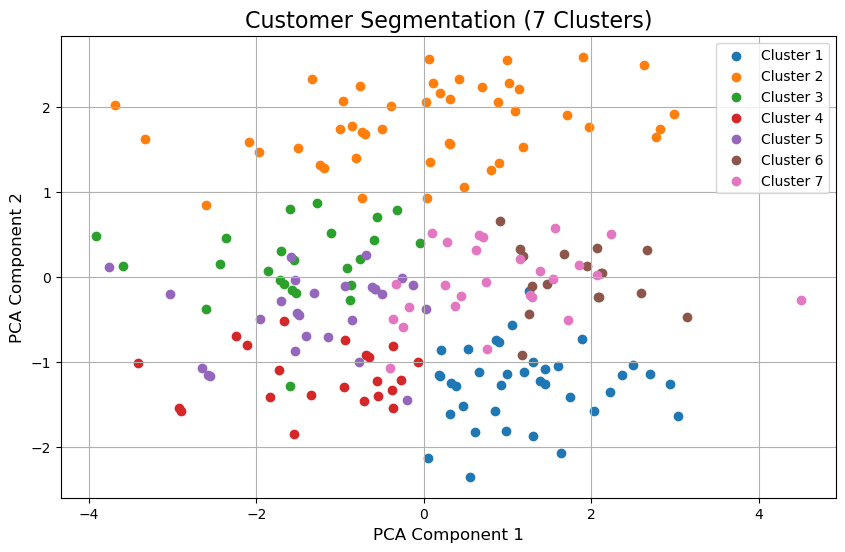

Davies-Bouldin Index for each cluster count:
2 Clusters: 1.8885
3 Clusters: 1.5828
4 Clusters: 1.1183
5 Clusters: 0.9832
6 Clusters: 1.0046
7 Clusters: 0.9447
8 Clusters: 0.9865
9 Clusters: 1.0332
10 Clusters: 1.0037

Optimal Number of Clusters: 7 with DB Index: 0.9447


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load datasets
transactions = pd.read_csv('C:/Users/CHIRAG JAGGA/Downloads/Transactions.csv')
products = pd.read_csv('C:/Users/CHIRAG JAGGA/Downloads/Products.csv')
customers = pd.read_csv('C:/Users/CHIRAG JAGGA/Downloads/Customers.csv')

# Merge datasets
transactions_products = pd.merge(transactions, products, on="ProductID", how="left")
customer_data = pd.merge(transactions_products, customers, on="CustomerID", how="left")

# Feature engineering
customer_features = customer_data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    num_transactions=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    unique_categories=("Category", "nunique")
).reset_index()

region_encoded = pd.get_dummies(customer_data.drop_duplicates(subset="CustomerID")[["CustomerID", "Region"]], 
                                columns=["Region"])

customer_features = pd.merge(customer_features, region_encoded, on="CustomerID", how="left")

# Normalize features
features = customer_features.drop(columns=["CustomerID"])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Clustering and DB Index calculation
db_scores = []
cluster_labels = {}
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    cluster_labels[n_clusters] = labels
    db_index = davies_bouldin_score(scaled_features, labels)
    db_scores.append((n_clusters, db_index))

# Optimal clusters
optimal_clusters = min(db_scores, key=lambda x: x[1])

# PCA for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
optimal_labels = cluster_labels[optimal_clusters[0]]

# Plot clusters
plt.figure(figsize=(10, 6))
for cluster in range(optimal_clusters[0]):
    cluster_points = pca_features[optimal_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster + 1}")

plt.title("Customer Segmentation (7 Clusters)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("Davies-Bouldin Index for each cluster count:")
for n_clusters, db_index in db_scores:
    print(f"{n_clusters} Clusters: {db_index:.4f}")

print(f"\nOptimal Number of Clusters: {optimal_clusters[0]} with DB Index: {optimal_clusters[1]:.4f}")
